# Imports and CoW

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
pd.set_option("mode.copy_on_write", True) # Will be default in pandas 3.0

# Read in data

In [4]:
pd.set_option("mode.copy_on_write", True)
cwd = Path().cwd()
wine_quality_red_filename = Path('winequality-red.csv')
wine_quality_white_filename = Path('winequality-white.csv')

if not wine_quality_red_filename.exists():
    raise FileNotFoundError(f"Dataset file not found: {wine_quality_red_filename}")
if not wine_quality_white_filename.exists():
    raise FileNotFoundError(f"Dataset file not found: {wine_quality_white_filename}")

wine_red = pd.read_csv(wine_quality_red_filename, sep=';') # 1599 data points
wine_white = pd.read_csv(wine_quality_white_filename, sep=';') # 4898 data points

# Question 1

In [ ]:
wine_red_quality = wine_red['quality'] # Range 3-8
wine_white_quality = wine_white['quality'] # Range 3-9

# Ranges found with below functions
print("Red wine quality scores range: [{0},{1}]".format(wine_red_quality.min(), wine_red_quality.max()))
print("White wine quality scores range: [{0},{1}]".format(wine_white_quality.min(), wine_white_quality.max()))

# Format bin size
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5]

# Make both plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))  # side by side

# Plot red wine quality
ax1.hist(wine_red_quality, bins=bins, color='red', edgecolor='black')
ax1.set_xticks(range(0, 11))
ax1.set_title("Red Wine Quality")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Count")

# Plot white wine quality
ax2.hist(wine_white_quality, bins=bins, color='gold', edgecolor='black')
ax2.set_xticks(range(0, 11))
ax2.set_title("White Wine Quality")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

# Question 2

In [ ]:
def create_boxplots(attribute, ylim_range):
    wine_red_attribute = wine_red[attribute]
    wine_white_attribute = wine_white[attribute]

    # 4 boxplots arranged in 2x2 fashion
    # Row 1 has red wine and white wine y limits matched
    # Row 2 has red wine and white wine y limits automatically set
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    

    for i in range(len(axes)):

        # Red
        axes[i][0].boxplot(wine_red_attribute)
        axes[i][0].set_title("Red Wine - {}".format(attribute))
        axes[i][0].set_xticks([]) # Hides the 1

        # White
        axes[i][1].boxplot(wine_white_attribute)
        axes[i][1].set_title("White Wine - {}".format(attribute))
        axes[i][1].set_xticks([]) # Hides the 1

        # Match y limits to increase ease of comparing median, Q1, Q3, and IQR
        # Otherwise, keep y limits automatically set to increase ease of seeing outliers
        if i == 0: 
            axes[i][0].set_ylim(ylim_range[0], ylim_range[1])
            axes[i][1].set_ylim(ylim_range[0], ylim_range[1])
            axes[i][0].set_ylabel("{} - match y limits".format(attribute))
        else:
            axes[i][0].set_ylabel("{} - automatic y limits".format(attribute))

    plt.tight_layout()
    plt.show()

create_boxplots('fixed acidity', (3,17))
create_boxplots('volatile acidity', (0, 1.7))
create_boxplots('pH', (2.6, 4.2))
create_boxplots('density', (0.98, 1.04))

# Question 3

In [ ]:
wine_red_scatter_subset = wine_red[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar']]
wine_white_scatter_subset = wine_white[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar']]

pd.plotting.scatter_matrix(wine_red_scatter_subset, alpha=0.2, figsize=(12, 12), c='red')
pd.plotting.scatter_matrix(wine_white_scatter_subset, alpha=0.2, figsize=(12, 12), c='gold')

# Question 4

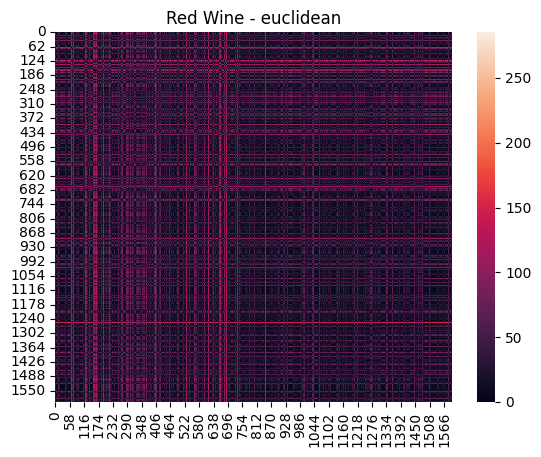

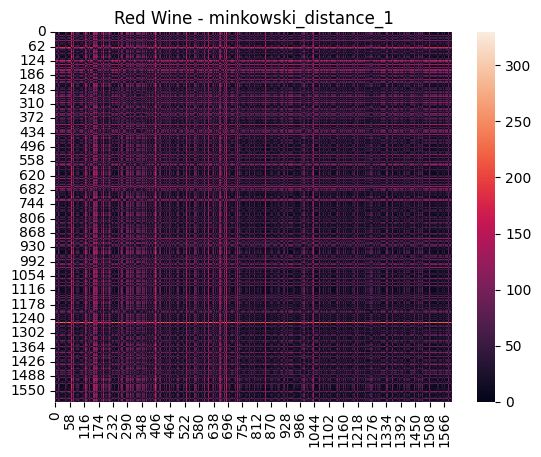

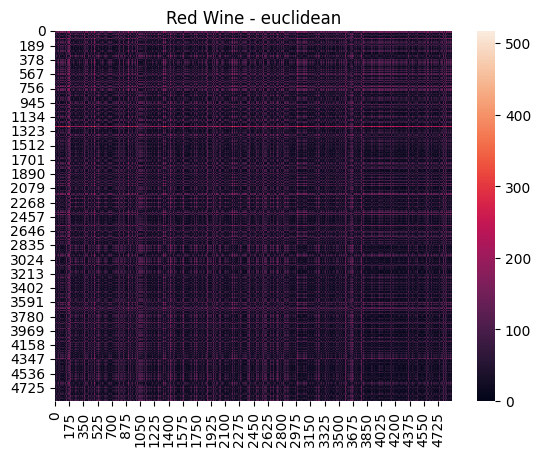

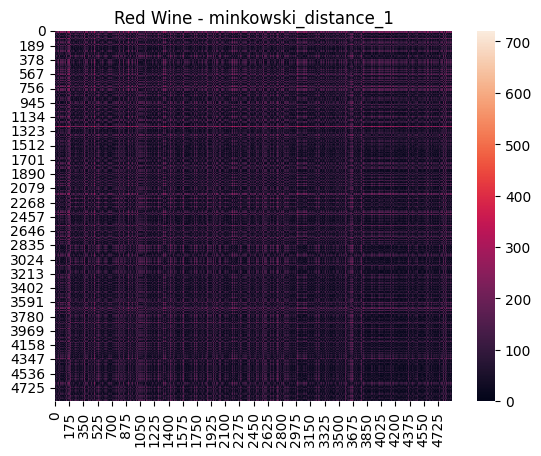

In [ ]:
from scipy.spatial.distance import pdist, squareform

inverse_covariance_matrix = None # Global variable to hold inverse covariance matrix

# Helper functions for distance functions
def minkowski_distance(rowA, rowB, r):
    return np.power(np.power(np.abs(rowA - rowB), r).sum(), 1 / r)

def calc_inv_covariance_matrix(data):
    x_mean = data.mean(axis = 0) # Get means
    x_centered = data - x_mean # Get centered data
    covariance_matrix = x_centered.T.dot(x_centered) / (len(data) - 1) # Covariance matrix
    return np.linalg.inv(covariance_matrix) # Inverse Covariance matrix

# Distance functions
def euclidean(rowA, rowB):
    return np.sqrt(np.square(rowA - rowB).sum())

def minkowski_distance_1(rowA, rowB):
    return minkowski_distance(rowA, rowB, 1)

def minkowski_distance_3(rowA, rowB):
    return minkowski_distance(rowA, rowB, 3)

def minkowski_distance_5(rowA, rowB):
    return minkowski_distance(rowA, rowB, 5)

def mahalanobis_distance(rowA, rowB):
    global inverse_covariance_matrix
    diff = rowA - rowB
    diff = diff.reshape(1, diff.shape[0])
    result = diff @ inverse_covariance_matrix @ diff.T
    result = result[0][0]
    result = np.sqrt(result)
    return result

def cosine_similarity(rowA, rowB):
    return rowA.dot(rowB) / np.sqrt(np.square(rowA).sum()) / np.sqrt(np.square(rowB).sum())

# TODO: Ask prof for clarification
def correlation(rowA, rowB): 
    rowA_hat = (rowA - np.mean(rowA)) / np.std(rowA)
    rowB_hat = (rowB - np.mean(rowB)) / np.std(rowB)
    return rowA_hat.dot(rowB_hat)

# Euclidean + Minkowski distance where r=1
def linear_combo(rowA, rowB):
    return euclidean(rowA, rowB) + minkowski_distance_1(rowA, rowB)

def generateMatrix(data, distance_func):
    matrix = squareform(pdist(data, metric=distance_func))
    return matrix

def generateMatricesForDataset(data, distance_func_list):
    global inverse_covariance_matrix
    inverse_covariance_matrix = calc_inv_covariance_matrix(data) # Set global inverse covariance matrix variable
    matrix_list = []
    for distance_func in distance_func_list:
         matrix = generateMatrix(data, distance_func)
         matrix_list.append(matrix)
    return matrix_list


wine_red_sorted_quality = wine_red.sort_values(by='quality')
wine_white_sorted_quality = wine_white.sort_values(by='quality')
wine_red_sorted_quality = wine_red_sorted_quality.drop(columns=['quality', 'alcohol']) # Need just first 10
wine_white_sorted_quality = wine_white_sorted_quality.drop(columns=['quality', 'alcohol']) # Need just first 10
wine_red_sorted_quality = wine_red_sorted_quality.reset_index(drop=True)
wine_white_sorted_quality = wine_white_sorted_quality.reset_index(drop=True)

wine_red_sorted_quality

wine_red_sorted_quality.to_csv('wine_red_sorted_quality', index=False)
wine_white_sorted_quality.to_csv('wine_white_sorted_quality', index=False)

distance_func_list = [euclidean, minkowski_distance_1, minkowski_distance_3, minkowski_distance_5, 
                      mahalanobis_distance, cosine_similarity, correlation, linear_combo]
# distance_func_list = [euclidean]
# distance_func_list = [euclidean, minkowski_distance_1]

red_wine_matrix_list = generateMatricesForDataset(wine_red_sorted_quality, distance_func_list)
white_wine_matrix_list = generateMatricesForDataset(wine_white_sorted_quality, distance_func_list)

for matrix_index, red_wine_matrix in enumerate(red_wine_matrix_list):
    sns.heatmap(red_wine_matrix).set(title='Red Wine - {}'.format(distance_func_list[matrix_index].__name__))
    plt.show()

for matrix_index, white_wine_matrix in enumerate(white_wine_matrix_list):
    sns.heatmap(white_wine_matrix).set(title='Red Wine - {}'.format(distance_func_list[matrix_index].__name__))
    plt.show()

# TODO: Consider changing positioning of x axis on graph
# TODO: Add labels to x and y axes 